# Aim
This notebook will provide a complete record of the steps used to generate sythetic data, construct a network, train the network, and validate the effectivness of that network. Hopefully by following cell by cell the procedure will be reproducable by any who are interested.

The Structure of this network will be as follows:
    Code will be presented, the **following** cell will provide an explanation of the code if that is nessesairy.

## Creating Synthetic Data

In [1]:
from astroSynth import POS, PVS

POS provide the basic object of astroSynth, POS can create many targets with one $\rightarrow$ many light curves each. POS also provides the foundation by which to quickly query these light curves and their assosicated Lomb-Scargle periodigrams

In [ ]:
dI = PVS()
dII = POS()
dI.load(directory='d-I')
dII.load(directory='d-II')

# IF YOU HAVE ALREADY RUN THE INSTANTIATE, BUILD, GENERATE, AND SAVE CODE RUN THESE COMMANDS TO LOAD THE PREVIOUSLY BUILT DATA AND SAVE YOURSELF SOME TIME

In [63]:
dI = PVS(Number=100000, name='d-I', noise_range=[0.001, 0.045])
dII = POS(number=100000, noise_range=[0.001, 0.045], numpoints=100000, name='d-II')

Here we generate the POS objects, parameters are as follows:

**number**: the number of objects to generate

**noise_range**: the range of noise values to pick from when inserting noise into the light curve

**numpoints**: the number of total exposure times from t=t0 to t=tf (there will be far fewer points in the final light curves if visit number > 1 as points in the time between visits will no longer be present)

**name**: name the survey will take when saved to disk

---
We create 2 surveys, _S and _V, in order that we might analyze data with single light curves per target and data with multiple light curves per target. _S will have single light curves per target and _V will have multiple light curves per target.

In [ ]:
dI.build(amp_range=[0, 0.02], freq_range=[0.0008333, 0.01667], L_range=[1, 3])
dII.build(amp_range=[0, 0.02], freq_range=[0.0008333, 0.01667], visits=[1, 50], L_range=[1, 3])

dI.generate(pfrac=0.5)
dII.generate(pfrac=0.5)

dI.save()
dII.save()

Next we generate the light curves. This is the most computationally expensive part of this section ($\sim 4.5$ hours on a 2016 mobile class intel i7 running at $\sim2.5 GHz$). We also spesify the fraction of targets that will be pulsators here in decimal. 0.5 is choosen so as to limit any sample biases that the network might pick up latter on.

Finally we save the Light Curve data to directories named the same name as the survey. Once you run this command you can load the data into a POS object at any time in the future as follows:
```python
from astroSynth import POS
survey = POS()
survey.load(directory='saved_survey')
```
where "saved_survey" is the name which was assigned to the POS object before it was saved. In this case that would be "dI" and "dII".

Again Note that this command can take a good amount of time ($\sim 15$ minutes) as it needs to write a lot of data to disk.

In [2]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
mpl.rc("savefig", dpi=150)
mpl.rc('font',**{'family':'serif','serif':['Times']})
mpl.rc('text', usetex=True)
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
%matplotlib inline

In [7]:
target = 2
visit = 0

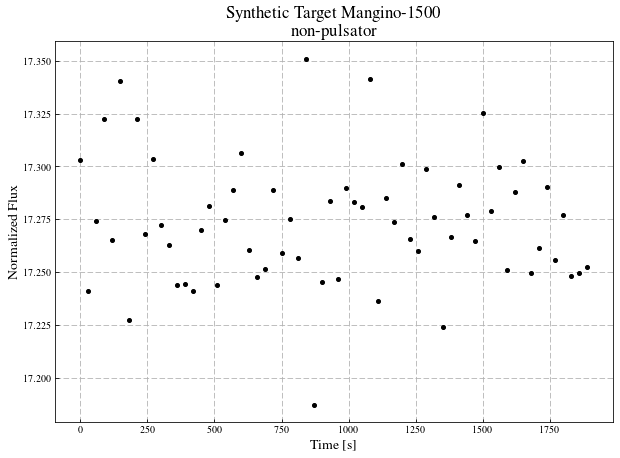

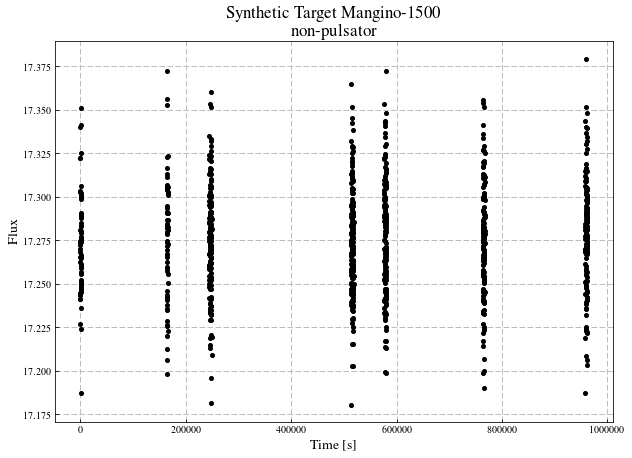

In [8]:
# Plot one visit from a target

plt.figure(figsize=(10, 7))
plt.plot(dII[target][visit][0], dII[target][visit][1], 'ko', markersize=4)
plt.ylabel('Normalized Flux', fontsize=14)
plt.xlabel('Time [s]', fontsize=14)
if dII[target][visit][2] == 1:
    pul = 'pulsator'
elif dII[target][visit][2] == 0.0:
    pul = 'non-pulsator'
plt.title('Synthetic Target {}\n{}'.format(dII[target].name, pul), fontsize=17)
plt.grid(linestyle='--')
plt.show()
plt.close()

# Plot the entirety of a targets light curve
plt.figure(figsize=(10, 7))
light_curve = dII.get_full_lc(n=target)
plt.plot(light_curve[0], light_curve[1], 'ko', markersize=4)
plt.ylabel('Flux', fontsize=14)
plt.xlabel('Time [s]', fontsize=14)
if dII[target][visit][2] == 1:
    pul = 'pulsator'
elif dII[target][visit][2] == 0.0:
    pul = 'non-pulsator'
plt.title('Synthetic Target {}\n{}'.format(dII[target].name, pul), fontsize=17)
plt.grid(linestyle='--')
plt.show()
plt.close()

Above we see two figures: Top -- Light Curve for the first visit of a target, Bottom -- the full light curve for a target. The visit structure is clearly visible in the full light curve.

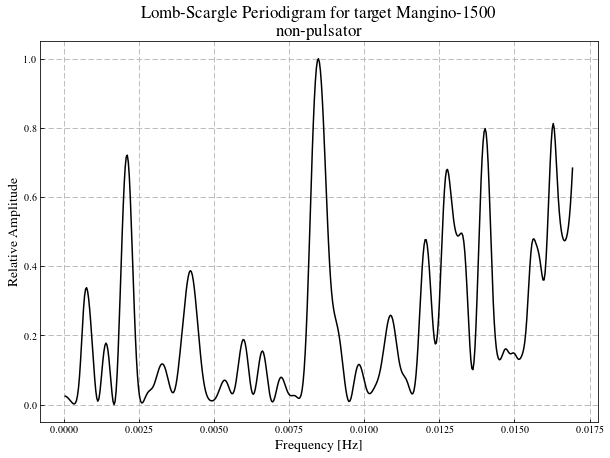

In [9]:
plt.figure(figsize=(10, 7))
lsp = dII.get_ft_sub(n=target, sub_element=visit, s=500)
if dII[target][visit][2] == 1:
    pul = 'pulsator'
elif dII[target][visit][2] == 0.0:
    pul = 'non-pulsator'
plt.plot(lsp[0], lsp[1], 'k')
plt.xlabel('Frequency [Hz]', fontsize=14)
plt.ylabel('Relative Amplitude', fontsize=14)
plt.title('Lomb-Scargle Periodigram for target {}\n{}'.format(dII[target].name, pul), fontsize=17)
plt.grid(linestyle='--')

## Setting Up An Artificial Neural Network (ANN)
We will use the python module Keras to construct and interface with our neural networks. We use an ANN to analyze the data of independant light curves as this is can be thought of as fundamentally a 1D problem.

In [ ]:
import numpy as np
from keras.utils import np_utils 
from keras.models import Sequential 
from keras.layers import Dense, Activation, Dropout 
from sklearn.cross_validation import train_test_split 

For this work we made use of Google's TensorFlow modlue to form the backend of Keras, no testing was done with the other avalible backend for Keras Theano.

In [4]:
def one_hot_encode_object_array(arr): 
    uniques, ids = np.unique(arr, return_inverse=True) 
    return np_utils.to_categorical(ids, len(uniques)) 

def save_model(model, name='Model'): 
    model_json = model.to_json() 
    with open(f'{name}.json', 'w') as f: 
        f.write(model_json) 
    model.save_weights(f'{name}.h5') 
    print('Saved Model to Disk')

Above are two "helper functions". 

one_hot_encode_object_array preforms a one hot encoding on based on possible classification. That is to say that if there are two possible states that each data entry could fall into, A and B, and we had a vector of the form [A, B, A, A, A, B, A,...,B, B, A, B, B]$^{T}$. Then preforming a one hot encode would return a vector of the form [[1, 0], [0, 1], [1, 0], [1, 0], [1, 0], [0, 1], [1, 0],...,[0, 1], [0, 1], [1, 0], [0, 1], [0, 1]]$^{T}$. This one hot encoding is essetial for a classification network to operate. 

The Second Function simply serialized and saves the model to a JSON file so that it may be accesed in future. If you do not have python 3.6 or greater installed then this function will not run properly due to its use of f-strings. To fix this change any strings prefeaced with f to one with format, so for example
```python
   with open(f'{name}.json', 'w') as f:
```
would become
```python
   with open('{name}.json'.format(name=name), 'w') as f:
```

In [58]:
def build_model(af='relu'): 
    model = Sequential() 
    model.add(Dense(500, input_dim=503)) 
    model.add(Activation(af)) 
    model.add(Dropout(0.2)) 
    model.add(Dense(500)) 
    model.add(Activation(af)) 
    model.add(Dropout(0.2)) 
    model.add(Dense(2)) 
    model.add(Activation('softmax')) 
     
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
 
    return model 

ANNmodel = build_model()

Here we build the structure of the ANN. I will walk threw each line

1. Defining the network as a linear set of layers
2. Add a fully connected layer with 503 inputs and 1000 outputs [INPUT]
  * We will pass into the network the full Lomb-Scarge Periodigram (LSP) which will be forced to have 500 frequency bins, as well as 3 parameters spesifically extracted from the LSP
      1. The maximum amplitude in the LSP
      2. The median value of the LSP
      3. The freququency of the maximum amplitude in the LSP
3. Add the layer to apply the activation function to the outputs of the previous layer
  * We use the rectified linear unit as an activation function.
4. Apply a 20 percent dropout to the network here
5. Same as layer 2 [HIDDEN]
6. Same as layer 3
7. Same as layer 5
8. Add an two value output layer [OUTPUT]
9. Apply the softmax activation function to the outputs to scale them between 0-1 in probability space.
10. We now compile the model together
  * loss defines how the network should measure its sucsess, as we aim to classify data entries into catagories we use catagorical_crossentropy
  * the optimizer defines how the model should modify itself, adam is a common omptimizer that provides adaquet results
  * metrics tells the network what we would like it to report, here we want accuracy which will be returened as a decimal percentage.
  
---
Once the function is defined to build the network the network is instantiated

## Using an ANN

In [5]:
from tqdm import tqdm
from hyperas.distributions import uniform

Progress bar module, if you installed astroSynth you have tqdm installed, we also import a module to tune hyperparameters, While this is not used here as they have been tuned prior to the rease of this notebook

In [ ]:
def load_model(name):
    json_file = open("{}.json".format(name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.load_weights("{}.h5".format(name))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [ ]:
ANNmodel = load_model('ANNmodel')

If you have built and trained a model in past, then use the above line to load that model (avoid the need to retrain it). If you have not run the following cells to train, validate and save a model to disk

In [ ]:
run_length = int(dI.size/(dI.size/10))-2
for i, (Freq, Amp, Class, N, pp) in tqdm(enumerate(dI.batch_get(batch_size=int(dI.size/10),
                                               ft=True, s=500)), total=run_length):
    if i >= run_length:
        break
    
    Xt = list()
    for x in Amp:
        Xtt = [j/max(x) for j in x]
        Xt.append(Xtt)
    X = np.array(Xt)

    X = np.insert(X, 0, [Freq[k][x.argmax()] for k, x in enumerate(X)], axis=1)   # Frequency of Max Amplitude
    X = np.insert(X, 0, [max(x) for x in Amp], axis=1)                            # Max Amplitude
    X = np.insert(X, 0, [np.median(x) for x in Amp], axis=1)                      # Median Value of LSP


    Y = one_hot_encode_object_array(Y)
    
    ANNmodel.fit(X, Y, verbose=1, nb_epoch=5, batch_size=100)

Here we see the training of the network, I will go line by line:

1. Defining the run length both so tqdm knows how large to draw the progress bar but also so that if one wants to run a subset of training they can, simply by changing that number.
  * I subtract one so that there will be some data the network has never seen, which we will latter use to validate the preformance of the network.
2. Open the for loop, an index value is gained through the use of an enumerate enviroment, and the returned tuple from PVS().batch_get is expanded. Here we define the size of the returned batch, tell it that we want fts (LSPs) returned (as opposed to light curves). And finally provided the number of frequency bins per ft. 
3. Check if the run length has been exceded.
4. if run length is exceded break the loop.
5. Take the amplitude list returned from PVS().batch_get() and cast it to a numpy array [X]
6. Insert into the 0th position of X the frequency of the maximum amplitude in the ft
7. Insert into the 0th position of X the maximum amplitude in the ft
8. Insert into the 0th position of X the medaian amplitude of the ft
9. run one hot encoding on the class list returned from PVS().batch_get() [Y]
10. Train the model on the input data, X, against the classification data, Y.
  * verbose = 1 provids the user with a progress bar at each trainish epoch
  * nb_epochs = n will train the network on the same data set n times, generally a balance must be found so that n if large enough to let the netowrk learn the datas features effectivly, but not so high that the network overfits the data

In [17]:
start = 80000
stop = 98000

Val_Freq, Val_Amp, Val_Class, Val_N = dI.__batch_get_ft__(start=start, stop=stop, s=500) 

Val_Y = one_hot_encode_object_array(Val_Class) 

Val_Xt = list()
for x in Val_Amp:
    Val_Xtt = [j/max(x) for j in x]
    Val_Xt.append(Val_Xtt)
Val_X = np.array(Val_Xt)
Val_X = np.insert(Val_X, 0, [Val_Freq[k][x.argmax()] for k, x in enumerate(Val_X)], axis=1) 
Val_X = np.insert(Val_X, 0, [max(x) for x in Val_Amp], axis=1) 
Val_X = np.insert(Val_X, 0, [np.median(x) for x in Val_Amp], axis=1) 

Here we build the validation data arrays. Using PVS().\__batch_get_ft\__() we can get a batch of fts covering a user defined range. Which we do using the start and stop parmenters. These are calculated to start where the training data left off and end at the end at the end of the data set. The rest of this cell is functionally identical to building the training data arrays as we did in the above cells.

In [ ]:
score = ANNmodel.evaluate(Val_X, Val_Y, verbose=0)
print('Model Loss: {:2f}, Model Accuracy: {:2f}%'.format(score[0], score[1]*100))

evaluating the model on the validation data provides the loss, and whatever metrics we compiled the model with (in thsi case accuracy) to see structure of the return from model.evaluate one can run model.metrics_names. 

While we now have a percentagae accuracy it would be nice to have a way of visualizing how this network classifies, as such we will plot all data points in a 2D parameter space and color them according to how the network classifies. We will also generate a second plot in the same parameter space, however this time coloring points based on what they actually are.

In [ ]:
predicted = ANNmodel.predict_classes(Val_X)

Here we use the Sequential().predict_classes() method to generate a list of classes for the validation data

In [60]:
save_model(ANNmodel, name='ANNmodel')

Saved Model to Disk


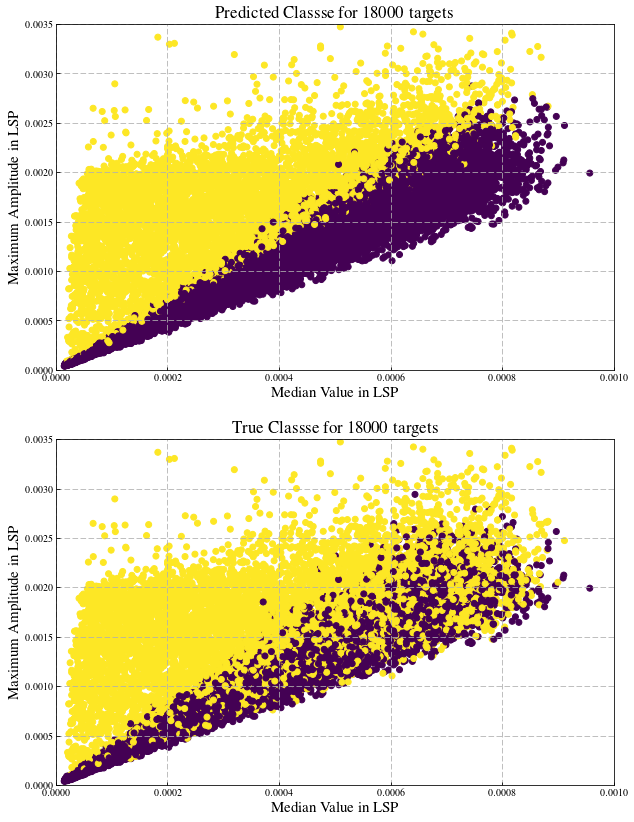

In [28]:
mp = [max(x) for x in Val_Amp]
mv = [np.median(x) for x in Val_Amp]

ct = Val_Class
cp = predicted

fig = plt.figure(figsize=(10, 14))
axpred = fig.add_subplot(211)
axtrue = fig.add_subplot(212)

axtrue.scatter(mv, mp, c=ct)
axpred.scatter(mv, mp, c=cp)

axtrue.set_xlim(0, 0.0010)
axtrue.set_ylim(0, 0.0035)
axpred.set_xlim(0, 0.0010)
axpred.set_ylim(0, 0.0035)

axtrue.set_title('True Classse for {} targets'.format(len(ct)), fontsize=17)
axpred.set_title('Predicted Classse for {} targets'.format(len(cp)), fontsize=17)

axtrue.set_xlabel('Median Value in LSP', fontsize=15)
axpred.set_xlabel('Median Value in LSP', fontsize=15)

axtrue.set_ylabel('Maximum Amplitude in LSP', fontsize=15)
axpred.set_ylabel('Maximum Amplitude in LSP', fontsize=15)

axtrue.grid(linestyle='--')
axpred.grid(linestyle='--')

Above we see a plot of maximum amplitude in LSP vs Median Value in LSP for both the predicted class and the true class. Yellow points are pulsators and purple points are non pulsators.

In [6]:
import pandas as pd

In [29]:
df = pd.DataFrame(data={'Max Peak':mp, 'Median Value':mv, 'True Class':ct, 'Predicted Class':cp})
df.to_csv('NetworkClassificationsPVS100000.csv', index=False)

And we save the data so that it may be used in the future

In [86]:
def build_regression_model(af='relu'):
    model = Sequential()
    model.add(Dense(1000, input_dim=500))
    model.add(Activation(af))
    model.add(Dropout(0.2))
    model.add(Dense(1000))
    model.add(Activation(af))
    model.add(Dropout(0.3))
    model.add(Dense(3))
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    return model

ANN_regression_Model = build_regression_model()

We build a model to be used for regression, in order to train this network we will generate a new dataset with only pulsators

In [8]:
dIb = PVS()
dIb.load(directory='d-Ib')

Data for regression is loaded, only run this if you have in past generated the data and saved it to disk (have run the following cell in the past).

In [ ]:
dIb = PVS(Number=100000, name='d-Ib', noise_range=[0.001, 0.045])
dIb.build(amp_range=[0, 0.02], freq_range=[0.0008333, 0.01667], L_range=[1, 1])
dIb.generate(pfrac=1)
dIb.save()

We generate a new dataset, one that has the same amplitude, frequency, and noise properties as d-I, but all 100000 light curves are pulsators, and we only allow one mode of pulsation to manifest. We do this as the network is only designed to deal with one mode of pulsation

In [79]:
def ouput_2_vector(l):
    l = list(l.items())
    l = transpose_list(l)[1]
    l = [x.tolist()[0] if str(type(x)) == "<class 'numpy.ndarray'>" else x for x in l][1:]
    return l

def transpose_list(l):
    return list(map(list, zip(*l)))

Here are some helper functions

In [ ]:
# Phase - Amp - Frequency
phase = list()
amp = list()
freq = list()
run_length = int(dIb.size/(dIb.size/10))-2
for i, (Freq, Amp, Class, N, pp) in tqdm(enumerate(dIb.batch_get(batch_size=int(dIb.size/10),
                                               ft=True, s=500)), total=run_length):
    if i >= run_length:
        break
    
    Xt = list()
    for x in Amp:
        Xtt = [j/max(x) for j in x]
        Xt.append(Xtt)
        
    Freq
    X = np.array(Xt)
    Y = pp
    for i, p in enumerate(Y):
        vec = ouput_2_vector(p)
        phase.append(vec[0])
        amp.append(vec[1])
        freq.append(vec[2])
        Y[i] = vec
    ANN_regression_Model.fit(X, Y, verbose=1, nb_epoch=5, batch_size=100)

We fit the ANN regression model to the data set, using similar properties to when we fit the ANN classification model

In [89]:
start = 80000
stop = 98000

Val_Freq, Val_Amp, Val_Class, Val_N, Val_pp = dIb.__batch_get_ft__(start=start, stop=stop, s=500) 


Val_Y = Val_pp
for i, p in enumerate(Val_Y):
    Val_Y[i] = ouput_2_vector(p)

Val_Xt = list()
for x in Val_Amp:
    Val_Xtt = [j/max(x) for j in x]
    Val_Xt.append(Val_Xtt)
Val_X = np.array(Val_Xt)

Calling the data for validation

In [90]:
score = ANN_regression_Model.evaluate(Val_X, Val_Y, verbose=0)
print('Model Loss: {:2f}, Model Accuracy: {:2f}%'.format(score[0], score[1]*100))

Model Loss: 0.273693, Model Accuracy: 99.616667%


In [91]:
predictions = ANN_regression_Model.predict(Val_X, verbose=1)

17600/18000 [============================>.] - ETA: 0s

In [ ]:
save_model(ANN_regression_Model, name='ANN_regression_Model')

We save the model to disk for future use

In [98]:
Val_Phases = np.array(Val_pp).T[0]
Val_Amps = np.array(Val_pp).T[1]
Val_Freqs = np.array(Val_pp).T[2]

pred_Phases = predictions.T[0]
pred_Amps = predictions.T[1]
pred_Freqs = predictions.T[2]

Extracting the parameters of interst from their arrays, in order that we might make a plot showing residuals of classification

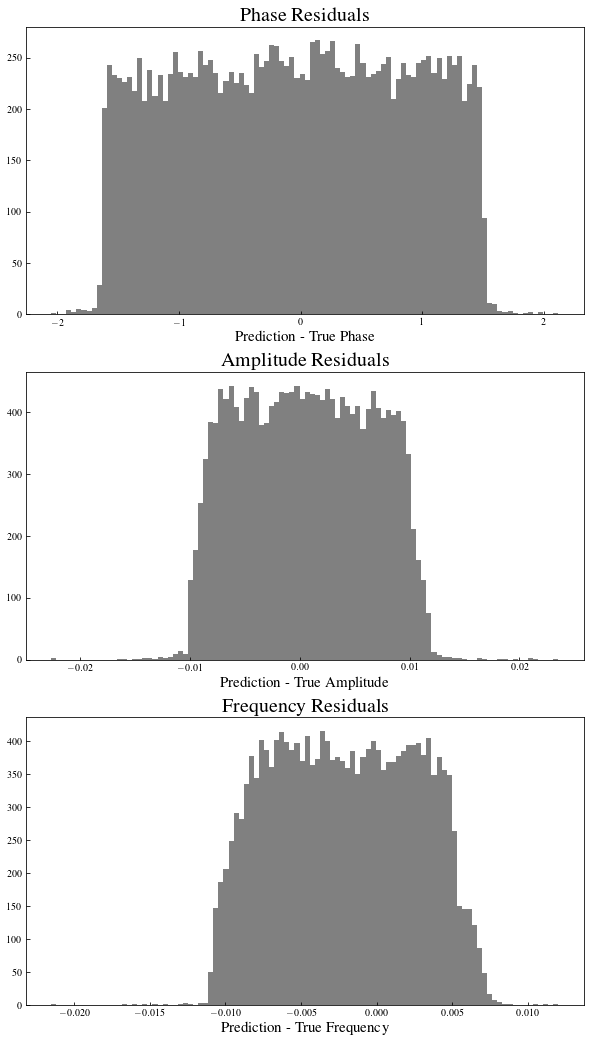

In [109]:
fig = plt.figure(figsize=(10, 18))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

ax1.hist(pred_Phases-Val_Phases, bins=100, color='grey')
ax2.hist(pred_Amps-Val_Amps, bins=100, color='grey')
ax3.hist(pred_Freqs-Val_Freqs, bins=100, color='grey')

ax1.set_title('Phase Residuals', fontsize=20)
ax2.set_title('Amplitude Residuals', fontsize=20)
ax3.set_title('Frequency Residuals', fontsize=20)

ax1.set_xlabel('Prediction - True Phase', fontsize=15)
ax2.set_xlabel('Prediction - True Amplitude', fontsize=15)
ax3.set_xlabel('Prediction - True Frequency', fontsize=15)

plt.savefig('RegressionANNResidualsHist.pdf', dpi=350, bbox_inches='tight')

From this plot we see that Frequency and Amplitude are predicted very accurctly by the network, however, phase is not. This is expected, as by going into a frequency domain we loose phsing information and therefore the network should not be able to accuratly predict phase.

## Visualizing the effectivness of the network

In [8]:
import difflib
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit

We import mode modules useful for accuracy visualization

In [9]:
def Gaussian(x, A, mu, sigma):
    return (A)*np.exp((-(x-mu)**2)/(2*(sigma**2)))+1

Defining a guassian function allows for use to fit this function to a data set in the future

In [47]:
step = 0.005
binedPointsTrue = dict()
binedPointsPred = dict()
bins = np.arange(0, 10, step)
for Bin in bins:
    step_name = Bin + (step/2)
    binedPointsPred[step_name] = list()
    binedPointsTrue[step_name] = list()
    for x, y, t, p in zip(mv, mp, ct, cp.tolist()):
        SigmaP = y/x
        if Bin <= SigmaP < Bin+step:
            binedPointsPred[Bin + (step/2)].append(p)
            binedPointsTrue[Bin + (step/2)].append(t)

Here we bin points in to sigma or S/N bins such that we might latter go in and extract percent accuracies at different signal to noise levels

In [48]:
Sigma = list()
Acc = list()
prevBin = 0
count = 0
for Bin in sorted(list(binedPointsTrue.keys())):
    if len(binedPointsPred[Bin]) != 0:
        Sigma.append(Bin)
        a=difflib.SequenceMatcher(None, binedPointsPred[Bin], binedPointsTrue[Bin])
        Acc.append(a.ratio())
Acc_svagol = savgol_filter(Acc, 15, 2)

Here we calculate that percent accuracy using the SequenceMatcher routine from the difflib module which is part of the python standard library. Then due to these being values which can inhereiently jump around alot (and becuase we are not looking to quantify the exact location where the network preforms work but rather too understand the general structure of its preformance) we apply a smooting filter so as we might better see the structure of the preformance

In [49]:
sfit = 0
efit = 400
fit, covar = curve_fit(Gaussian, Sigma[sfit:efit], Acc[sfit:efit], p0=[0.5, 3, 1])
fit_xplot = np.linspace(1.5, 10, 500)
fit_yplot = Gaussian(fit_xplot, *fit)

Using standard fitting routienes we fit a gaussian to the smoothe curve

In [61]:
one_sig_err = np.sqrt(np.diag(covar))
mu = fit[1]
mu_err = one_sig_err[1]
print('Guassian Fit Centroid is: {:1.2f}±{:1.2f}σ'.format(mu, mu_err))

Guassian Fit Centroid is: 2.78±0.02σ


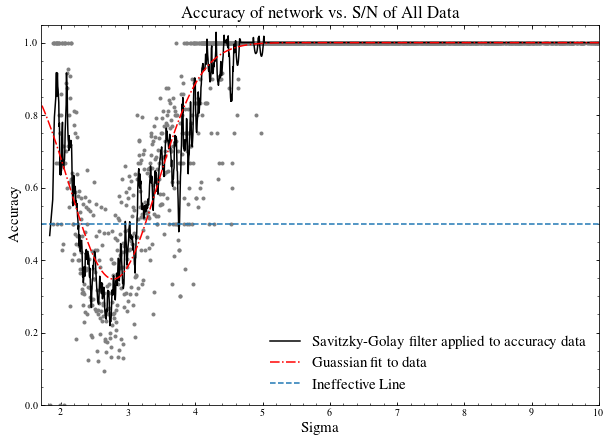

In [50]:
X_minorLocator = MultipleLocator(0.2)
Y_minorLocator = MultipleLocator(0.05)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

ax.plot(Sigma, Acc, 'o', alpha=1, color='grey', markersize=3, label='')
ax.plot(Sigma, Acc_svagol, 'k', label='Savitzky-Golay filter applied to accuracy data')
ax.plot(fit_xplot, fit_yplot, linestyle='-.', color='red', label='Guassian fit to data')

ax.set_xlabel('Sigma', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_title('Accuracy of network vs. S/N of All Data', fontsize=17)

ax.set_xlim(1.7, 10)
ax.set_ylim(0, 1.05)

ax.axhline(y=0.5, linestyle='--', label='Ineffective Line')

ax.xaxis.set_minor_locator(X_minorLocator)
ax.yaxis.set_minor_locator(Y_minorLocator)

plt.tick_params(
    axis='x',
    which='both',
    bottom='on',
    top='on')
plt.tick_params(
    axis='y',
    which='both',
    left='on',
    right='on')

ax.legend(loc='best', fontsize=15, frameon=False)

And when we plot we can see the network begins to falter where we would expect it to falter, the region wheere the noise band and the pulsatoion band interact (around 3.5 sigma with the values used in this notebook).

In [52]:
df = pd.DataFrame(data={'Acc':Acc, 'Acc_svagol':Acc_svagol,'Sigma':Sigma})
df.to_csv('ANNPerformanceQuantified.csv', index=False)

And we save the data so that it may be used in the future

## Setting up a Convolutional Neural Network (CNN)
We will continue to use Keras to construct and interface with our netowkrs now that we will be working with CNNs. We use an CNN to analyze the data of multi-visit light targets, as we can take this data and turn it into images quite nautrally, and CNNs are well suited for image analysis.

In [10]:
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.layers.convolutional import Conv2D, MaxPooling2D

In [11]:
def build_CNN(af='relu'):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(1, 300, 300), padding='same', activation=af,
                     kernel_constraint=maxnorm(3), data_format='channels_first'))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3, 3), padding='same', activation=af, kernel_constraint=maxnorm(3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation=af, kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.3))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
    
    return model

CNNModel = build_CNN()

Here we build the convolutional neural network, structurally this is similar to when we built the ANN, we are still placing networks in sequential order. Here we have added a few new types of layers, a 2-Dimensional Convolution layer (Conv2D), a 2-Dimensional Max Pooling layer (MaxPooling2D), and a layer to move from 2D to 1D (Flatten). Due to the similarity with ANN creation I will not go line by line here, rather I will highlight the important elements which do not show up in ANN creation.

1. The Conv2D Layer
  * The first Conv2D layer is used as input here. The input shape (3, 50, 300) means that this netowrk expects an array that is 50 elements high by 300 elements wide, and each element is made of 3 sub elements. For example an image that is 50x300.
  * A Conv2D layers first argument is the number of convolutions it will preform (filter size), this can be thought of as one part of the size of the output, here we have a filter size of 32.
  * After the filter size we define the size of the kernal, so here we define a 3 by 3 kernal.
  * padding='same' addes padding to the input so that it will match the output dimension
  * kernel_constraint = maxnorm(3) helps keep values from blowing up
2. Max Pooling Layers take the largest value from some kernal and use that to represent the entire kerna, these help shrink the size of the data. So in this case we take the largest value from 2x2 grids to represent those grids.
3. Flatten inputs upon it when the output, so an input of (None, 64, 32, 32) would become an output of (None, 65536)

In [ ]:
samples = 300
run_length = int(dII.size/(dII.size/10))-2
batch_size = int(dII.size/10)
for index, (imgs, freq_bin, cs, ID) in tqdm(enumerate(dII.batch_get(spect=True, dim=samples,
                                                                             batch_size=batch_size, s=samples,
                                                                             NormalizeSpect=True)),
                                          total=run_length):
    if index >= run_length:
        break
    X = imgs.tolist()
    Y = cs
    X = np.array(X)
    x_use = X.reshape(len(X), 1, samples, samples)
    y_ohe = one_hot_encode_object_array(Y)
    CNNModel.fit(x_use, y_ohe, epochs=1, batch_size=10)

We extract the spectrograms (all normalized to one) from the survey data using the batch_get method. As CNNs work best on square datasets we square out our spectrograms by defineing the dim paramerter equal to the s (samples) parameter, this forces the height of the returnes spectrogram to equal the number of frequency bins, if there are not enough visits to match this one to one then it will stretch all visits equally, if there are too many then it will compress the contributions of visits together. All interpolation is done via cubic splines. 

Spectrograms are then reshaped to the dimensionallity the network expects (None, 1, 300, 300). Classes are one hot encoded, and the model is fit to the data

In [13]:
save_model(CNNModel, name='CNNModel')

Saved Model to Disk


Here we save the model, in future we can now load model using the "model_from_json" method instead of retraing a model

In [ ]:
start = 80000
stop = 100000
val_imgs, val_freq_bin, val_cs, val_ID = dII.__batch_get_spect__(start=start, stop=stop, Normalize=True,
                                                                            s=300, dim=300)
val_imgs = np.array(val_imgs.tolist())
val_imgs = val_imgs.reshape(len(val_imgs), 1, samples, samples)
val_cs_ohe = one_hot_encode_object_array(val_cs)

We extract the remaining data (which was not used in training) to be used as validaion data, and reshape it appropriatly (in the same manner as was done to the training data)

In [ ]:
cnn_score = CNNModel.evaluate(val_imgs, val_cs_ohe, verbose=0)
print('Model Loss: {:2f}, Model Accuracy: {:2f}%'.format(cnn_score[0], cnn_score[1]*100))

In [ ]:
cnn_predicted = CNNModel.predict_classes(val_imgs)

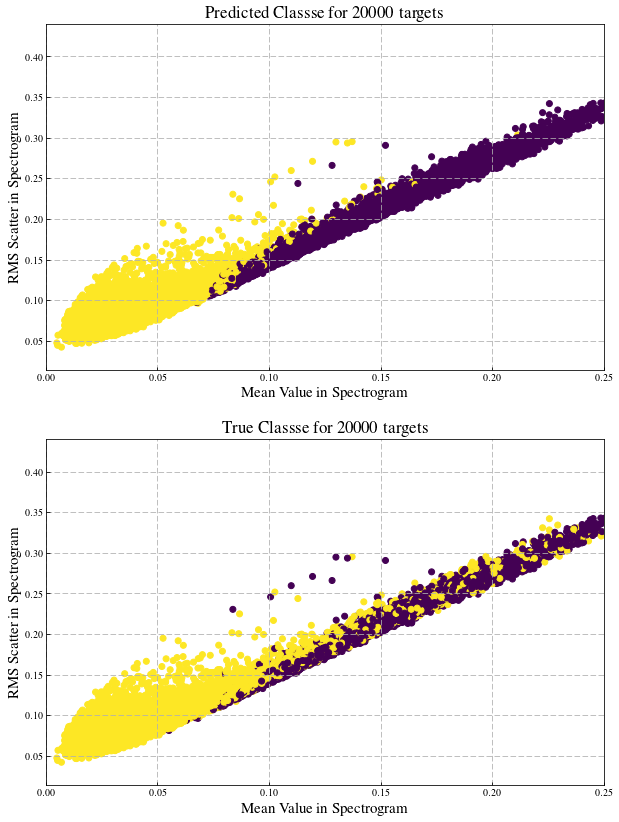

In [19]:
rms = [np.sqrt(np.mean(np.square(x))) for x in val_imgs]
med = [np.mean(x) for x in val_imgs]

ct = val_cs
cp = cnn_predicted

fig = plt.figure(figsize=(10, 14))
axpred = fig.add_subplot(211)
axtrue = fig.add_subplot(212)

axtrue.scatter(med, rms, c=ct)
axpred.scatter(med, rms, c=cp)

axtrue.set_xlim(0, 0.25)
# axtrue.set_ylim(0, 0.0025)
axpred.set_xlim(0, 0.25)
# axpred.set_ylim(0, 0.0025)

axtrue.set_title('True Classse for {} targets'.format(len(ct)), fontsize=17)
axpred.set_title('Predicted Classse for {} targets'.format(len(cp)), fontsize=17)

axtrue.set_xlabel('Mean Value in Spectrogram', fontsize=15)
axpred.set_xlabel('Mean Value in Spectrogram', fontsize=15)

axtrue.set_ylabel('RMS Scatter in Spectrogram', fontsize=15)
axpred.set_ylabel('RMS Scatter in Spectrogram', fontsize=15)

axtrue.grid(linestyle='--')
axpred.grid(linestyle='--')

import pandas as pd
df = pd.DataFrame(data={'rms':rms, 'mv':med, 'ct':ct, 'cp':cp})
df.to_csv('CNNrmsVSmv.csv', index=False)

In [ ]:
binedPointsTrue = dict()
binedPointsPred = dict()
step = 0.1
bins = np.arange(2, 21, step)
for Bin in bins:
    step_name = Bin + (step/2)
    binedPointsPred[step_name] = list()
    binedPointsTrue[step_name] = list()
    for i, (r, p, t) in enumerate(zip(rms, cnn_predicted, val_cs)):
        SN = 1/r
        if Bin <= SN < Bin + step and t == 1:
            binedPointsPred[step_name].append(p)
            binedPointsTrue[step_name].append(t)

As we did when investigating the performance of the ANN Model, here we bin points together. However, instead of by sigma we bin points by Signal To Noise Ratio

In [ ]:
SN = list()
CNNAcc = list()
for Bin in sorted(list(binedPointsTrue.keys())):
    if len(binedPointsPred[Bin]) != 0:
        SN.append(Bin)
        a=difflib.SequenceMatcher(None, binedPointsPred[Bin], binedPointsTrue[Bin])
        CNNAcc.append(a.ratio())
CNNAcc_svagol = savgol_filter(CNNAcc, 19, 2)
CNNAcc_svagol = [x if x <= 1 else 1 for x in CNNAcc_svagol]

Applying a smoothing filter to the data and caluclating the percent accuracy using the difflib library

In [44]:
def sigmoid(x, L, k, x0):
    return 1/(1+np.exp(-k*(x-x0)))

We define a sigmoid to fit the accurcy of pulsator classification metric

In [53]:
def d_Sigmoid(x, L, k, x0):
    return (L*k*np.exp(-k*(x-x0)))/((1+np.exp(-k*(x-x0)))**2)

And the sigmoid deriviticec so that we might see how the accuracy changes given a certain signal to noise ratio

In [ ]:
sfit = 0
efit = 90
fit, covar = curve_fit(sigmoid, SN[sfit:efit], CNNAcc[sfit:efit], p0=[1, 0.6, 7])
fit_xplot = np.linspace(1, 20, 500)
fit_yplot = sigmoid(fit_xplot, *fit)

Running the fit routine

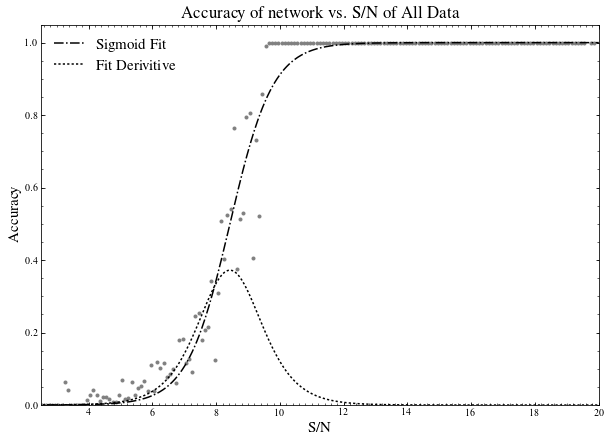

In [57]:
X_minorLocator = MultipleLocator(0.2)
Y_minorLocator = MultipleLocator(0.05)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

ax.plot(SN, CNNAcc, 'o', alpha=1, color='grey', markersize=3, label='')
# ax.plot(SN, CNNAcc_svagol, 'k', label='Savitzky-Golay filter applied to accuracy data')
ax.plot(fit_xplot, fit_yplot, linestyle='-.', color='black', label='Sigmoid Fit')
ax.plot(fit_xplot, d_Sigmoid(fit_xplot, *fit), linestyle=':', color='black', label='Fit Derivitive')

ax.set_xlabel('S/N', fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_title(r'Accuracy of network vs. S/N of All Data', fontsize=17)

ax.set_xlim(2.5, 20)
ax.set_ylim(0, 1.05)


ax.xaxis.set_minor_locator(X_minorLocator)
ax.yaxis.set_minor_locator(Y_minorLocator)

plt.tick_params(
    axis='x',
    which='both',
    bottom='on',
    top='on')
plt.tick_params(
    axis='y',
    which='both',
    left='on',
    right='on')

ax.legend(loc='best', fontsize=15, frameon=False)

import pandas as pd
df = pd.DataFrame(data={'SN':SN, 'CNNAcc':CNNAcc, 'CNNAcc_svagol':CNNAcc_svagol})
df.to_csv('CNNQuantifiedPerfomance.csv', index=False)

Notice how the rate of change of accuray has a maximum at 40%